## Setup

In [5]:
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.auto import tqdm

sys.path.insert(0, os.path.abspath('../'))

from src.dataset.loaders import get_dataloaders
from src.utils.metrics import evaluate_model_full, print_metrics
from src.utils.plotting import plot_confusion_matrix, plot_training_curves
from src.utils.logging import save_checkpoint, log_experiment

SEED = 21
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
BATCH_SIZE = 32
EPOCHS = 10
LR = 1e-4  # Lower LR for fine-tuning
MODEL_NAME = 'dinov2_vitb14'

# Get directories
NOTEBOOK_DIR = Path(os.getcwd()) / 'notebooks'
RESULTS_DIR = NOTEBOOK_DIR / 'results' / 'dinov2'
DATA_DIR = Path(os.getcwd()) / 'data'


torch.manual_seed(SEED)
np.random.seed(SEED)

print(f"Device: {DEVICE}")
print(f"Model: {MODEL_NAME}")
print(f"Results directory: {RESULTS_DIR}")
print(f"Data directory: {DATA_DIR}")

Device: mps
Model: dinov2_vitb14
Results directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2
Data directory: /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/data


## Load DINOv2 Model

DINOv2 is available via torch hub. Load the base model and add a classification head.

In [6]:
class DINOv2Classifier(nn.Module):
    """DINOv2 with classification head"""
    def __init__(self, model_name='dinov2_vitb14', num_classes=3, freeze_backbone=False):
        super().__init__()
        
        # Load pretrained DINOv2
        print(f"Loading {model_name} from torch hub...")
        self.backbone = torch.hub.load('facebookresearch/dinov2', model_name)
        
        # Get embedding dimension
        self.embed_dim = self.backbone.embed_dim
        print(f"Embedding dimension: {self.embed_dim}")
        
        # Optionally freeze backbone
        if freeze_backbone:
            for param in self.backbone.parameters():
                param.requires_grad = False
            print("Backbone frozen - only training classification head")
        
        # Classification head
        self.head = nn.Sequential(
            nn.LayerNorm(self.embed_dim),
            nn.Linear(self.embed_dim, num_classes)
        )
    
    def forward(self, x):
        # Get CLS token embedding
        features = self.backbone(x)
        # Classify
        return self.head(features)

# Create model
model = DINOv2Classifier(
    model_name=MODEL_NAME,
    num_classes=3,
    freeze_backbone=False  # Fine-tune entire model
).to(DEVICE)

print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

Loading dinov2_vitb14 from torch hub...


Using cache found in /Users/stahlma/.cache/torch/hub/facebookresearch_dinov2_main
/Users/stahlma/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/stahlma/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/stahlma/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vitb14/dinov2_vitb14_pretrain.pth" to /Users/stahlma/.cache/torch/hub/checkpoints/dinov2_vitb14_pretrain.pth


100%|██████████| 330M/330M [00:59<00:00, 5.78MB/s] 


Embedding dimension: 768

Total parameters: 86,584,323
Trainable parameters: 86,584,323


## Load Datasets

In [13]:
from src.dataset.loaders import compute_class_weights

# Load ASDID (source domain)
print("Loading ASDID dataset...")
asdid_train_loader, asdid_val_loader, asdid_test_loader, full_dataset, train_indices, val_indices, test_indices = get_dataloaders(
    dataset_name='ASDID',
    data_root=f'{DATA_DIR}/ASDID',
    batch_size=BATCH_SIZE,
    seed=SEED
)

# Compute class weights from the full dataset
print("\nComputing class weights for ASDID...")
class_weights, class_counts = compute_class_weights(full_dataset, num_classes=3)

# Load MH (target domain)
print("\nLoading MH dataset...")
mh_train_loader, mh_val_loader, mh_test_loader, mh_full_dataset, mh_train_indices, mh_val_indices, mh_test_indices = get_dataloaders(
    dataset_name='MH',
    data_root=f'{DATA_DIR}/MH-SoyaHealthVision/Soyabean_Leaf_Image_Dataset',
    batch_size=BATCH_SIZE,
    seed=SEED
)

CLASS_NAMES = ['Healthy', 'Rust', 'Frogeye']

print(f"\nASDID - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_indices)}")
print(f"MH - Train: {len(mh_train_indices)}, Val: {len(mh_val_indices)}, Test: {len(mh_test_indices)}")

Loading ASDID dataset...
Loaded 4799 samples for ASDID dataset.

Computing class weights for ASDID...
📊 Class distribution:
   Class 0: 1632 samples (weight: 0.979)
   Class 1: 1627 samples (weight: 0.983)
   Class 2: 1540 samples (weight: 1.038)

Loading MH dataset...
Loaded 1225 samples for MH dataset.

ASDID - Train: 3359, Val: 719, Test: 721
MH - Train: 857, Val: 183, Test: 185


## Training Configuration

In [14]:
# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights.to(DEVICE))

# Optimizer - lower LR for fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.01)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

print(f"Optimizer: AdamW (lr={LR}, weight_decay=0.01)")
print(f"Scheduler: CosineAnnealingLR")
print(f"Loss: CrossEntropyLoss with class weights {class_weights.tolist()}")

Optimizer: AdamW (lr=0.0001, weight_decay=0.01)
Scheduler: CosineAnnealingLR
Loss: CrossEntropyLoss with class weights [0.9794915914535522, 0.982501745223999, 1.0380066633224487]


## Train on ASDID

In [15]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    pbar = tqdm(train_loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{100.*correct/total:.2f}%'})
    
    return total_loss / len(train_loader), 100. * correct / total

def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(val_loader), 100. * correct / total

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

print("\nTraining DINOv2 on ASDID...\n")

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, asdid_train_loader, criterion, optimizer, DEVICE)
    val_loss, val_acc = validate(model, asdid_val_loader, criterion, DEVICE)
    scheduler.step()
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"LR: {scheduler.get_last_lr()[0]:.6f}\n")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        save_checkpoint(
            model,
            RESULTS_DIR / f'best_{MODEL_NAME}.pth',
            metadata={'epoch': epoch, 'val_acc': val_acc}
        )
        print(f"✅ Best model saved (val_acc: {val_acc:.2f}%)\n")

print(f"\n🏆 Training completed! Best validation accuracy: {best_val_acc:.2f}%")


Training DINOv2 on ASDID...

Epoch 1/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 1.0824, Train Acc: 44.51%
Val Loss: 0.8444, Val Acc: 53.82%
LR: 0.000098

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 53.82%)

Epoch 2/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.8001, Train Acc: 60.43%
Val Loss: 0.8369, Val Acc: 60.78%
LR: 0.000090

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 60.78%)

Epoch 3/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.6702, Train Acc: 68.23%
Val Loss: 0.6881, Val Acc: 73.02%
LR: 0.000079

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 73.02%)

Epoch 4/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.5681, Train Acc: 75.97%
Val Loss: 0.5765, Val Acc: 78.03%
LR: 0.000065

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 78.03%)

Epoch 5/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.4376, Train Acc: 82.61%
Val Loss: 0.5105, Val Acc: 77.75%
LR: 0.000050

Epoch 6/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.2367, Train Acc: 91.07%
Val Loss: 0.3648, Val Acc: 87.90%
LR: 0.000035

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 87.90%)

Epoch 7/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.1321, Train Acc: 95.00%
Val Loss: 0.3718, Val Acc: 89.85%
LR: 0.000021

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 89.85%)

Epoch 8/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.0711, Train Acc: 97.95%
Val Loss: 0.3601, Val Acc: 89.71%
LR: 0.000010

Epoch 9/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.0167, Train Acc: 99.35%
Val Loss: 0.4165, Val Acc: 90.68%
LR: 0.000002

✅ Saved checkpoint to /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth
✅ Best model saved (val_acc: 90.68%)

Epoch 10/10


Training:   0%|          | 0/105 [00:00<?, ?it/s]

Train Loss: 0.0055, Train Acc: 99.91%
Val Loss: 0.4253, Val Acc: 90.40%
LR: 0.000000


🏆 Training completed! Best validation accuracy: 90.68%


## Plot Training History

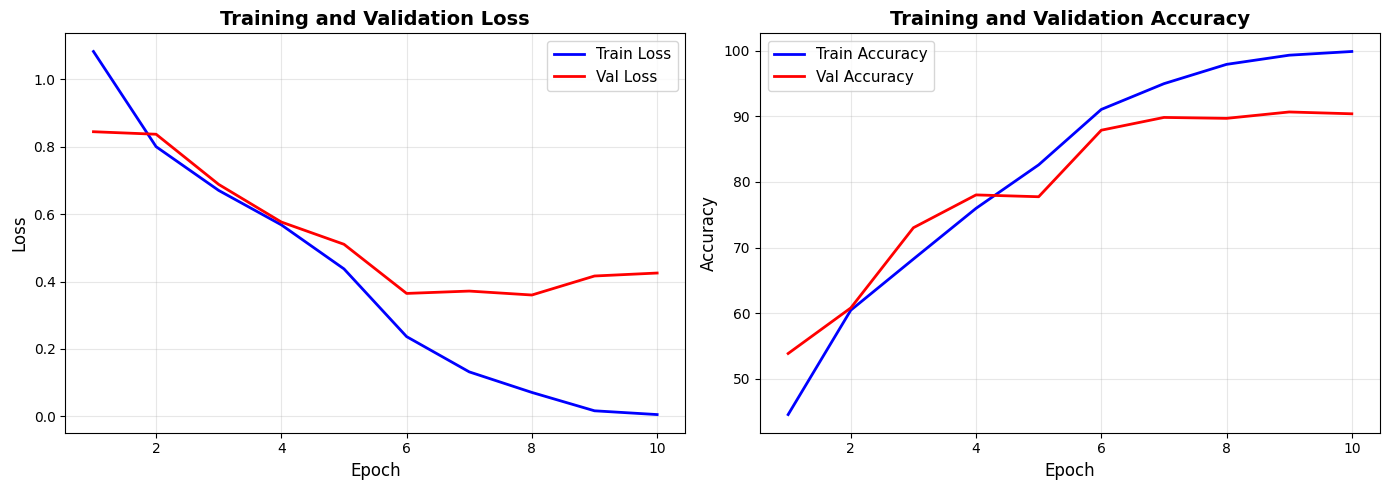

In [16]:
plot_training_curves(history, save_path=RESULTS_DIR / f'{MODEL_NAME}_training.png')
plt.show()

## Evaluate on ASDID Test Set (In-Domain)

Loading dinov2_vitb14 from torch hub...


Using cache found in /Users/stahlma/.cache/torch/hub/facebookresearch_dinov2_main


Embedding dimension: 768
✅ Loaded checkpoint from /Users/stahlma/Desktop/01_Studium/11_Thesis/soybean/thesis_poc/notebooks/results/dinov2/best_dinov2_vitb14.pth

            DINOv2 - ASDID Test Set (In-Domain)             
Accuracy:  0.9015
Precision: 0.9003
Recall:    0.9005
F1 Score:  0.9004

---------------------Per-Class Metrics:---------------------

Healthy:
  Precision: 0.9225
  Recall:    0.9154
  F1 Score:  0.9189
  Support:   260

Rust:
  Precision: 0.9237
  Recall:    0.9316
  F1 Score:  0.9277
  Support:   234

Frogeye:
  Precision: 0.8546
  Recall:    0.8546
  F1 Score:  0.8546
  Support:   227



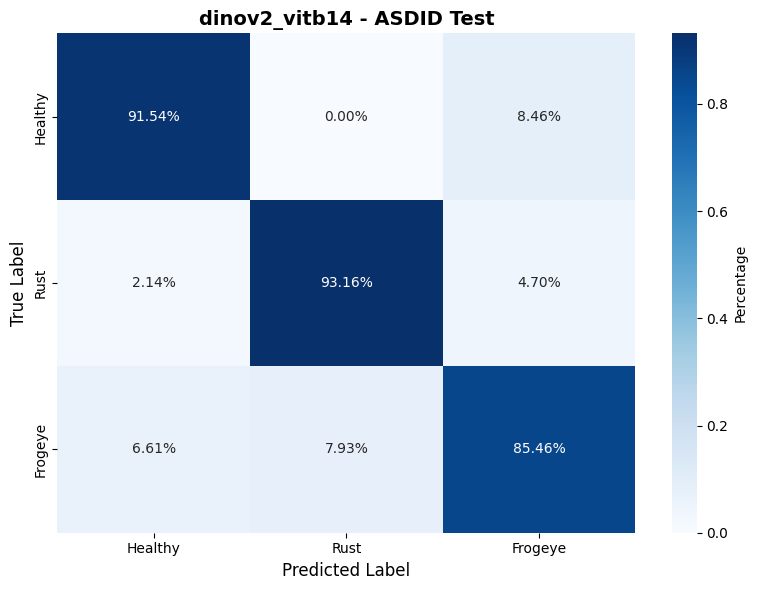

✅ Logged experiment to results/experiment_registry.csv


PosixPath('results/experiment_registry.csv')

In [17]:
# Load best model
from src.utils.logging import load_checkpoint

model_eval = DINOv2Classifier(model_name=MODEL_NAME, num_classes=3).to(DEVICE)
load_checkpoint(RESULTS_DIR / f'best_{MODEL_NAME}.pth', model_eval, device=DEVICE)
model_eval.eval()

# Evaluate
asdid_metrics = evaluate_model_full(model_eval, asdid_test_loader, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(asdid_metrics, title="DINOv2 - ASDID Test Set (In-Domain)")

plot_confusion_matrix(
    asdid_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - ASDID Test',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_asdid_test.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_asdid',
    metrics=asdid_metrics,
    model_name=MODEL_NAME,
    dataset='ASDID',
    method='baseline',
    save_dir='results'
)

## Evaluate on MH Test Set (Cross-Domain)

**Critical Test**: How well does DINOv2 transfer from ASDID (lab) to MH (field) without any adaptation?


            DINOv2 - MH Test Set (Cross-Domain)             
Accuracy:  0.6432
Precision: 0.5277
Recall:    0.6221
F1 Score:  0.5450

---------------------Per-Class Metrics:---------------------

Healthy:
  Precision: 0.4912
  Recall:    0.9333
  F1 Score:  0.6437
  Support:   30

Rust:
  Precision: 0.8660
  Recall:    0.6412
  F1 Score:  0.7368
  Support:   131

Frogeye:
  Precision: 0.2258
  Recall:    0.2917
  F1 Score:  0.2545
  Support:   24



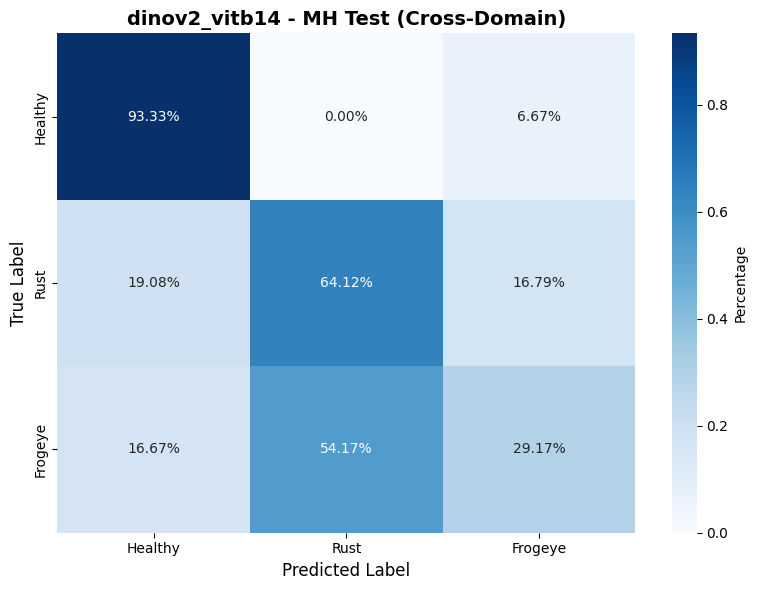

✅ Logged experiment to results/experiment_registry.csv


PosixPath('results/experiment_registry.csv')

In [18]:
mh_metrics = evaluate_model_full(model_eval, mh_test_loader, device=DEVICE, class_names=CLASS_NAMES)
print_metrics(mh_metrics, title="DINOv2 - MH Test Set (Cross-Domain)")

plot_confusion_matrix(
    mh_metrics['confusion_matrix'],
    class_names=CLASS_NAMES,
    title=f'{MODEL_NAME} - MH Test (Cross-Domain)',
    save_path=RESULTS_DIR / f'{MODEL_NAME}_mh_test.png'
)
plt.show()

log_experiment(
    experiment_name=f'{MODEL_NAME}_mh',
    metrics=mh_metrics,
    model_name=MODEL_NAME,
    dataset='MH',
    method='baseline',
    save_dir='results'
)

## Results Summary

In [19]:
print("\n" + "="*80)
print(f"{MODEL_NAME.upper()} - Cross-Domain Performance".center(80))
print("="*80)
print(f"{'Dataset':<15} {'Accuracy':>10} {'Precision':>10} {'Recall':>10} {'F1':>10}")
print("-"*80)
print(f"{'ASDID (In)':<15} {asdid_metrics['accuracy']:>10.4f} {asdid_metrics['precision']:>10.4f} "
      f"{asdid_metrics['recall']:>10.4f} {asdid_metrics['f1']:>10.4f}")
print(f"{'MH (Cross)':<15} {mh_metrics['accuracy']:>10.4f} {mh_metrics['precision']:>10.4f} "
      f"{mh_metrics['recall']:>10.4f} {mh_metrics['f1']:>10.4f}")
print("="*80)

f1_drop = asdid_metrics['f1'] - mh_metrics['f1']
print(f"\n📊 F1 Drop (ASDID→MH): {f1_drop:.4f} ({f1_drop/asdid_metrics['f1']*100:.1f}% relative)")
print(f"\n🎯 Comparison to ViT-B/16: MH F1 = {mh_metrics['f1']:.4f} (ViT baseline: ~0.72)")
print(f"   Expected improvement: {(mh_metrics['f1'] - 0.72):.4f}")


                    DINOV2_VITB14 - Cross-Domain Performance                    
Dataset           Accuracy  Precision     Recall         F1
--------------------------------------------------------------------------------
ASDID (In)          0.9015     0.9003     0.9005     0.9004
MH (Cross)          0.6432     0.5277     0.6221     0.5450

📊 F1 Drop (ASDID→MH): 0.3554 (39.5% relative)

🎯 Comparison to ViT-B/16: MH F1 = 0.5450 (ViT baseline: ~0.72)
   Expected improvement: -0.1750
